In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import collections

import tensorflow as tf

C:\Users\wlyip\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TGSSaltDataset(tf.data.Dataset):
    # constructor
    def __init__(self, root_path, file_list, transform=None):
        self.root_path = root_path
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        file_id = self.file_list[index]
        # image folder + path
        image_folder = os.path.join(self.root_path, 'images')
        image_path = os.path.join(image_folder, file_id + '.png')
        # mask folder + path
        mask_folder = os.path.join(self.root_path, 'masks')
        mask_path = os.path.join(mask_folder, file_id + '.png')
        
        # read it
        image = np.array(cv2.imread(image_path))#, dtype=np.uint8)
        mask = np.array(cv2.imread(mask_path))#, dtype=np.uint8)
        
        if self.transform is not None:
            return self.transform(image, mask)
        else:
            return image, mask

In [3]:
train_path = 'datasets/train'
file_list = [filename[:-4] for filename in os.listdir(train_path + '/images')]

In [4]:
dataset = TGSSaltDataset(train_path, file_list)

In [5]:
# function to visualize the images
def plot2x2array(image, mask):
    # invoke matplotlib
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

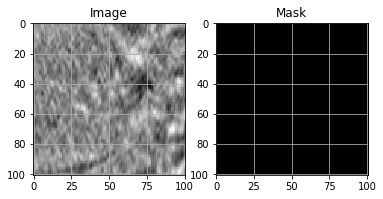

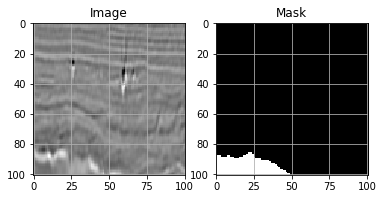

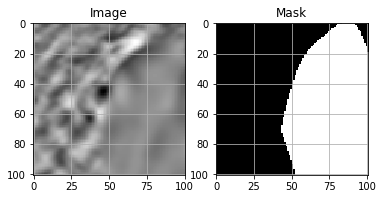

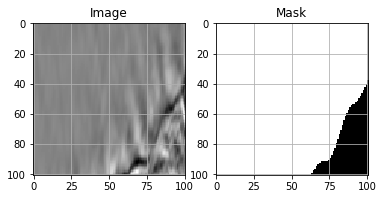

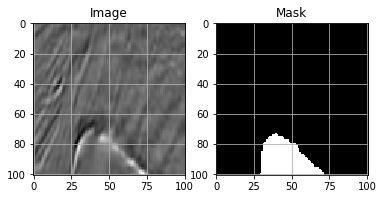

In [6]:
# print the images
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2array(image, mask)

In [ ]:
def positional_augmentation(joint):
    # Random crop
    crop_height = 50
    crop_width = 50
    aug = mx.image.RandomCropAug(size=(crop_width, crop_height)) # Watch out: weight before height in size param!
    aug_joint = aug(joint)
    # Deterministic resize
    resize_size = 100
    aug = mx.image.ResizeAug(resize_size)
    aug_joint = aug(aug_joint)
    # Add more translation/scale/rotation augmentations here...
    return aug_joint


def color_augmentation(base):
    # Only applied to the base image, and not the mask layers.
    aug = mx.image.BrightnessJitterAug(brightness=0.2)
    aug_base = aug(base)
    # Add more color augmentations here...
    return aug_base


def joint_transform(base, mask):
    ### Convert types
    base = base.astype('float32')/255
    mask = mask.astype('float32')/255
    
    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = mx.nd.concat(base, mask, dim=2)

    ### Augmentation Part 1: positional
    aug_joint = positional_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    ### Augmentation Part 2: color
    aug_base = color_augmentation(aug_base)

    return aug_base, aug_mask